In [123]:
from math import exp, log

class Value:
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), "**")
    
    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    out = Value(exp(self.data), (self,), "e^")

    def _backward():
      self.grad += exp(self.data) * out.grad
    out._backward = _backward
    return out 

  def tanh(self):
    t = (exp(self.data) - exp(-self.data)) / (exp(-self.data) + exp(self.data))
    out = Value(t, (self,), "tanh")

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def sigmoid(self):
    s = 1 / (1 + exp(-self.data))
    out = Value(s, (self,), "sigmoid")

    def _backward():
      self.grad += s * (1-s)
    out._backward = _backward
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), "ReLU")
    
    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

  def log(self):
    self = self if isinstance(self, Value) else Value(self)
    out = Value(log(self.data), (self,), "log")

    def _backward():
      self.grad += out.grad / self.data
    out._backward = _backward
    return out

  def backward(self):
    # build topological graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for v in reversed(topo):
      v._backward()

  def __neg__(self):
    return self*-1

  def __radd__(self, other): # other + self
        return self + other

  def __sub__(self, other): # self - other
      return self + (-other)
  
  def __rsub__(self, other): # other - self
        return other + (-self)

  def __rmul__(self, other): # other * self
      return self * other

  def __truediv__(self, other): # self / other
        return self * other**-1

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

In [111]:
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  deno = sum(counts)
  out = [c/deno for c in counts]
  return out

In [112]:
# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

2.1755153626167147


In [124]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

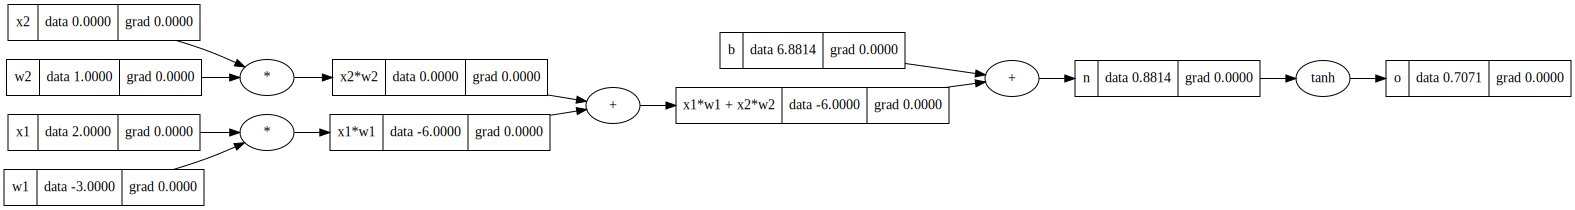

In [125]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [126]:
o.backward()

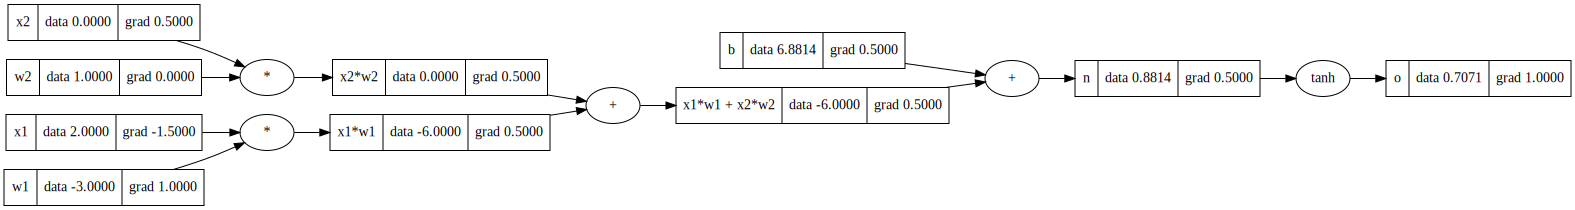

In [127]:
draw_dot(o)

In [159]:
import random

class Module:
  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

  def parameters(self):
    return []

class Neuron(Module):
  def __init__(self, nin, nonlin="linear"):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(0.0)
    self.nonlin = nonlin

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    if self.nonlin == "relu":
      return act.relu()
    elif self.nonlin == "sigmoid":
      return act.sigmoid()
    elif self.nonlin == "tanh":
      return act.tanh()
    else:
      return act 
  
  def parameters(self):
    return self.w + [self.b]

  def __repr__(self):
    return f"{self.nonlin}Neuron({len(self.w)})"

class Layer(Module):
  def __init__(self, nin, nout, **kwargs):
    self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

  def __call__(self, x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out
  
  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

  def __repr__(self):
    return f"Layer of [{','.join(str(n) for n in self.neurons)}]"

class MLP(Module):

  def __init__(self, nin, nouts, activation_func="sigmoid"):
    sz = [nin] + nouts
    nonlins = [activation_func for _ in range(len(nouts)-1)] + ["linear"]
    self.layers = [Layer(sz[i], sz[i+1], nonlin=nonlins[i]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __repr__(self) -> str:
    return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [160]:
nn = MLP(3, [4,4,1])

In [161]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, 1.0, 1.0],
    [1.0, 2.0, -3.0],
    [2.0, -1.0, -2.0],
]

ys = [-1.0, 1.0, 1.0, 1.0]

ypred = [nn(x) for x in xs]

In [162]:
ypred

[Value(data=-0.19331667945097478, grad=0),
 Value(data=-0.15194429055610514, grad=0),
 Value(data=-0.21965307115601768, grad=0),
 Value(data=-0.18168915851856607, grad=0)]

In [163]:
loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.861656509537433, grad=0)

In [164]:
loss.backward()

In [165]:
nn.layers[2].neurons[0].w[0]

Value(data=0.45441757273558925, grad=-3.568579363799082)

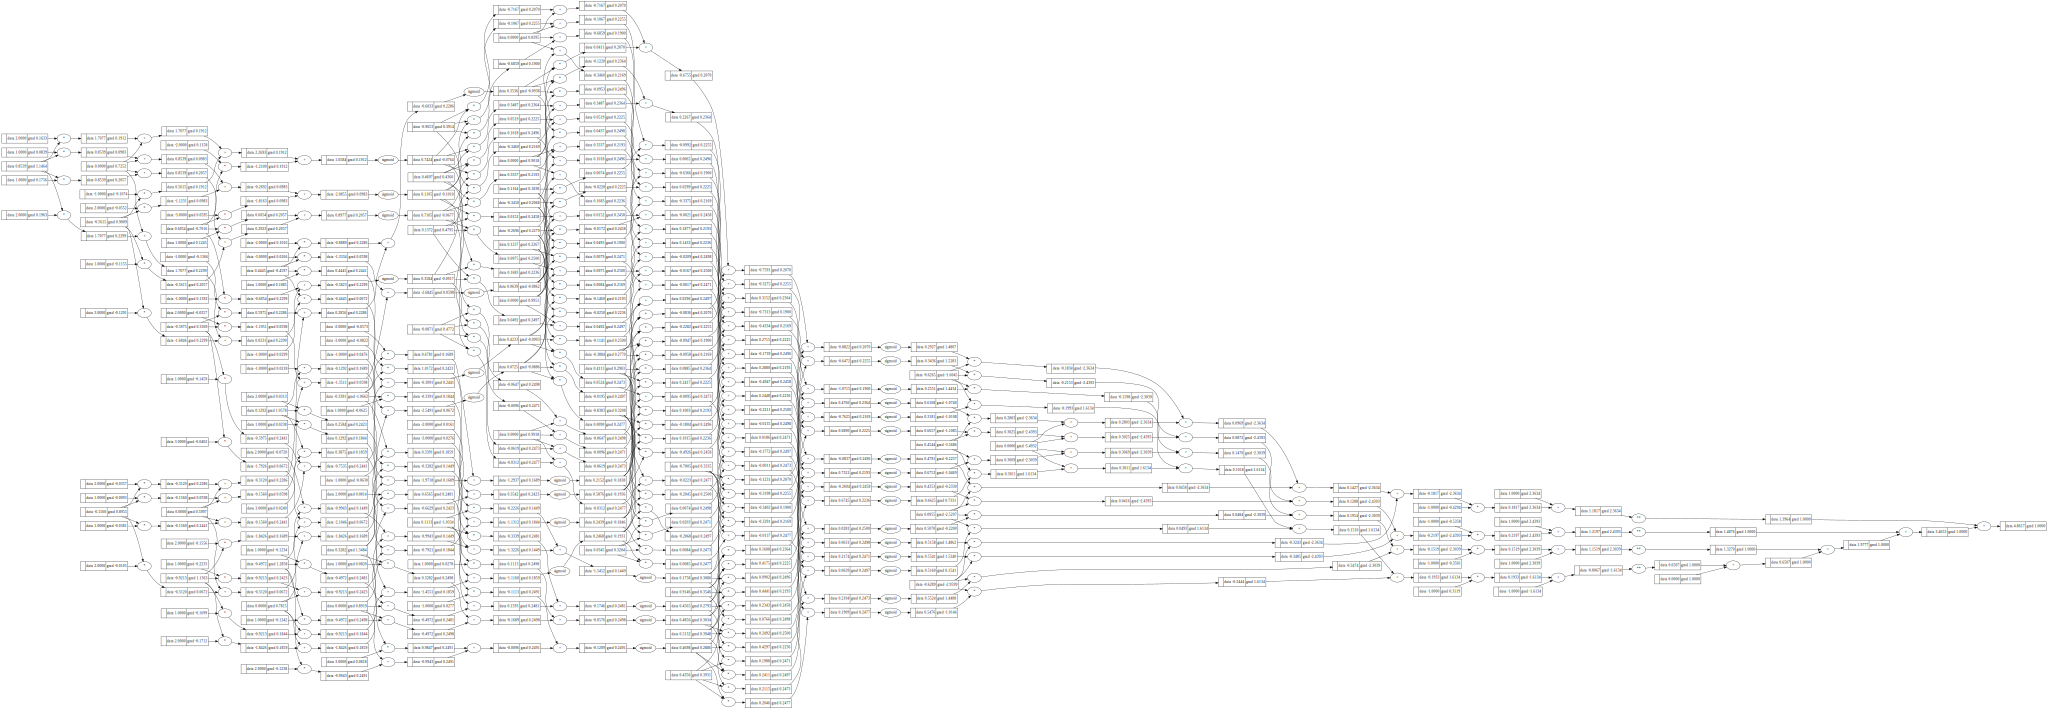

In [166]:
draw_dot(loss)